In [1]:
import sys
sys.path.append("../") # ugly way to have .py files in the PYTHONPATH

In [2]:
import math
import tqdm
import numpy as np
import pandas as pd
import graph_tool.all as gt 
from itertools import combinations

from utils import get_config, read_keyword_lists

In [3]:
np.random.seed(77)
gt.seed_rng(77)

In [4]:
DIR = ".."
CONFIG = "../config.yaml"

In [5]:
config = get_config(CONFIG, section="files")
data_dir = f"{DIR}/{config['data_dir']}"
info_filename = config["info_filename"]

In [6]:
df = pd.read_csv(f"{data_dir}/{info_filename}", index_col=0)
len(df)

2423


## Fixed keywords

In [7]:
config_keywords = get_config(CONFIG, section="process")
keywords = config_keywords["fixed_keywords"]
df_keywords = ( 
    pd.read_csv(f"{data_dir}/keywords_{info_filename}", index_col=0)
    .set_index("id")
) == "YES"
#_keywords

In [8]:
paper2node = {}
g = gt.Graph(directed=False)
node_label = g.new_vp("string")
node_id = g.new_vp("string")

In [9]:
for _, row in df.iterrows():
    node = g.add_vertex()
    node_id[node] = row["id"]
    node_label[node] = row["title"]
    paper2node[row["id"]] = node

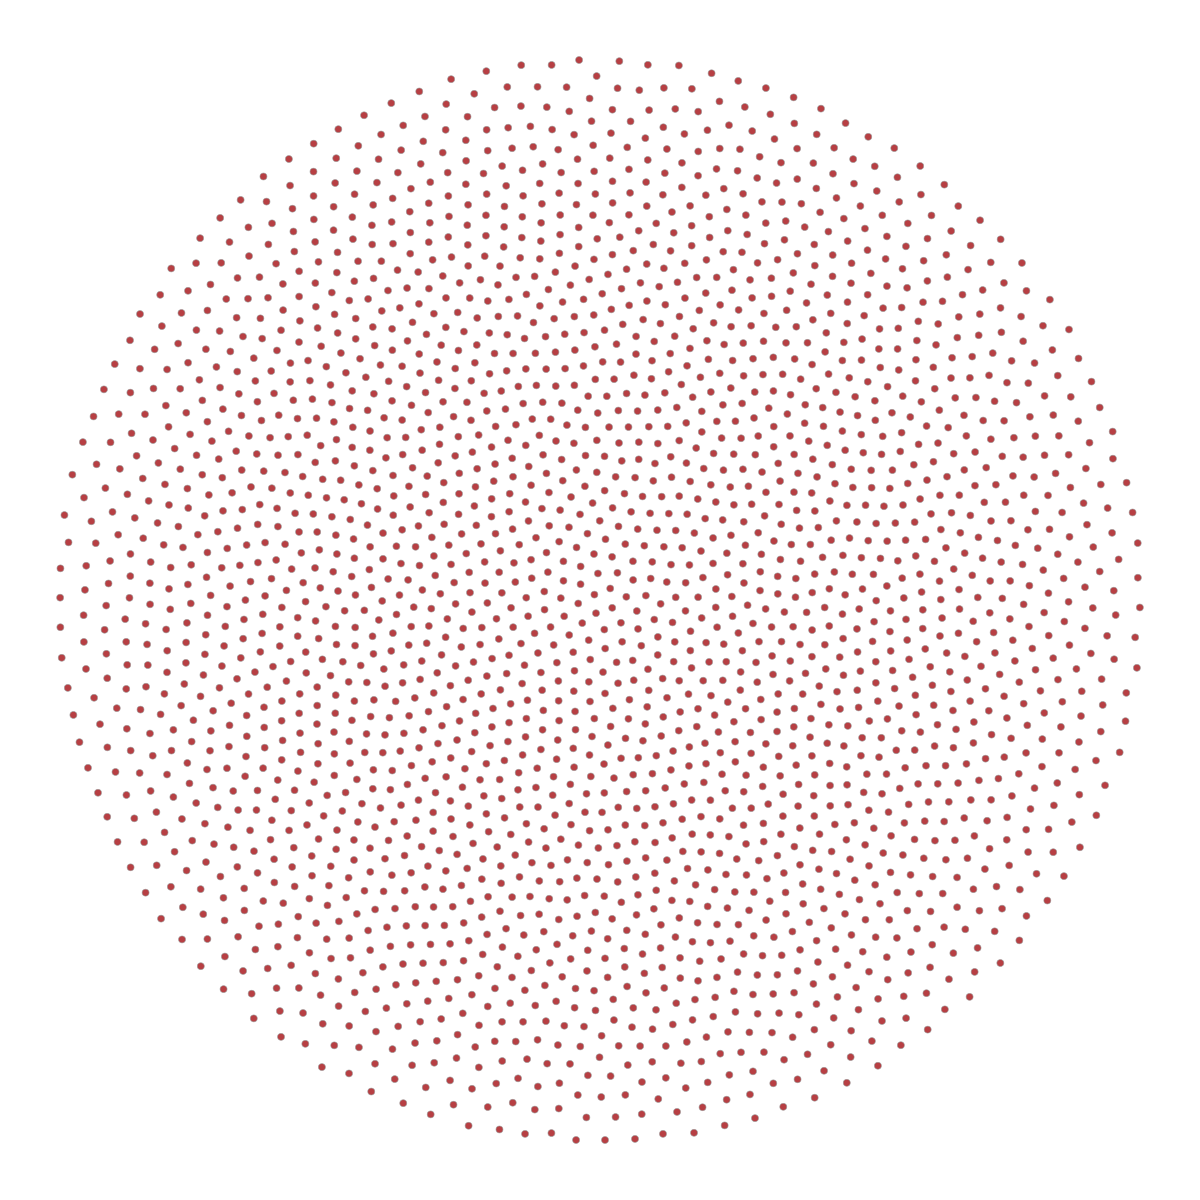

2423

In [10]:
gt.graph_draw(g); 
len(list(g.vertices()))

In [11]:
edge_weight = g.new_ep("int") 
# add edges
edges = set()
edges_counts = dict()

for keyword in df_keywords.columns:
    common_papers = list(df_keywords[df_keywords[keyword] == True].index)
    print(keyword, len(common_papers))
    for id1, id2 in combinations(common_papers, 2):
        if (id1, id2) not in edges and (id2, id1) not in edges:
            edges.add((id1, id2))
        if (id1, id2) in edges_counts:
            edges_counts[(id1, id2)] += 1
        else:
            edges_counts[(id1, id2)] = 1

for (id1, id2) in edges:
    e = g.add_edge(paper2node[id1], paper2node[id2])
    edge_weight[e] = edges_counts[(id1, id2)] 
    
#for paper1, paper2 in tqdm.tqdm(combinations(df["id"], 2)):
    #e = g.add_edge(paper2node[paper1], paper2node[paper2])
#    sel = df_keywords[df_keywords.index.isin((paper1, paper2))]
#    count = (sel.sum() == 2).sum()
#    if count > 0:
#        e = g.add_edge(paper2node[paper1], paper2node[paper2])
#        edge_weight[e] = count

reinforcement learning 220
evolutionary algorithms 435
bayesian optimisation 116
multi-objective optimisation 594
supernet 274
weight sharing 332
differentiable optimisation 470
zero cost proxies or training free 99
hardware aware search 316
surrogate models 386


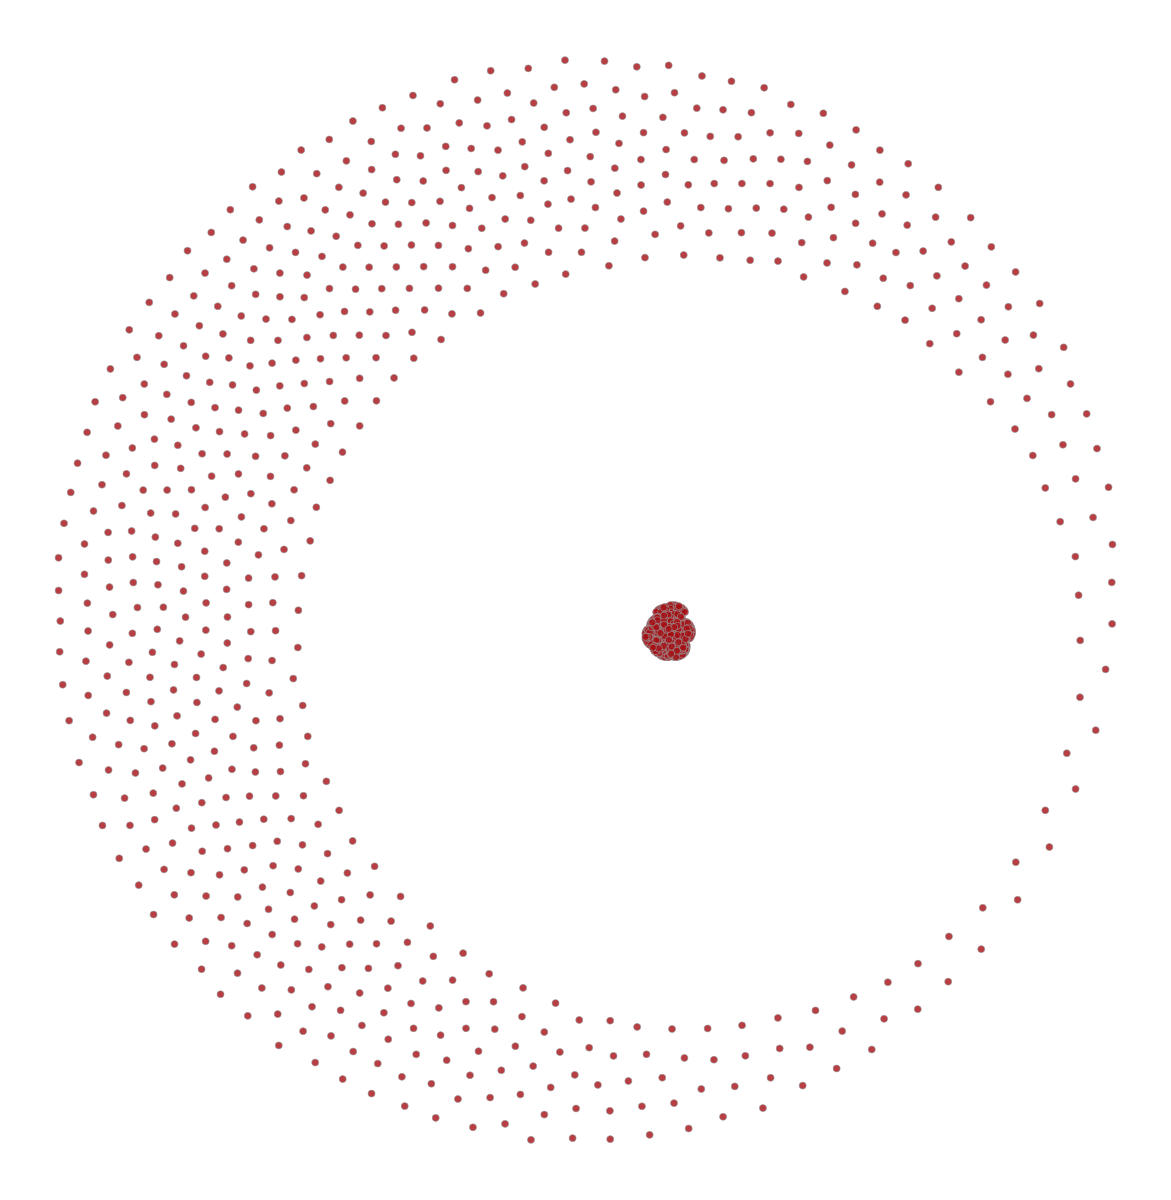

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f10012bdfd0, at 0x7f10020b6840>

In [12]:
gt.graph_draw(g, edge_pen_width=edge_weight, edge_color="gray")

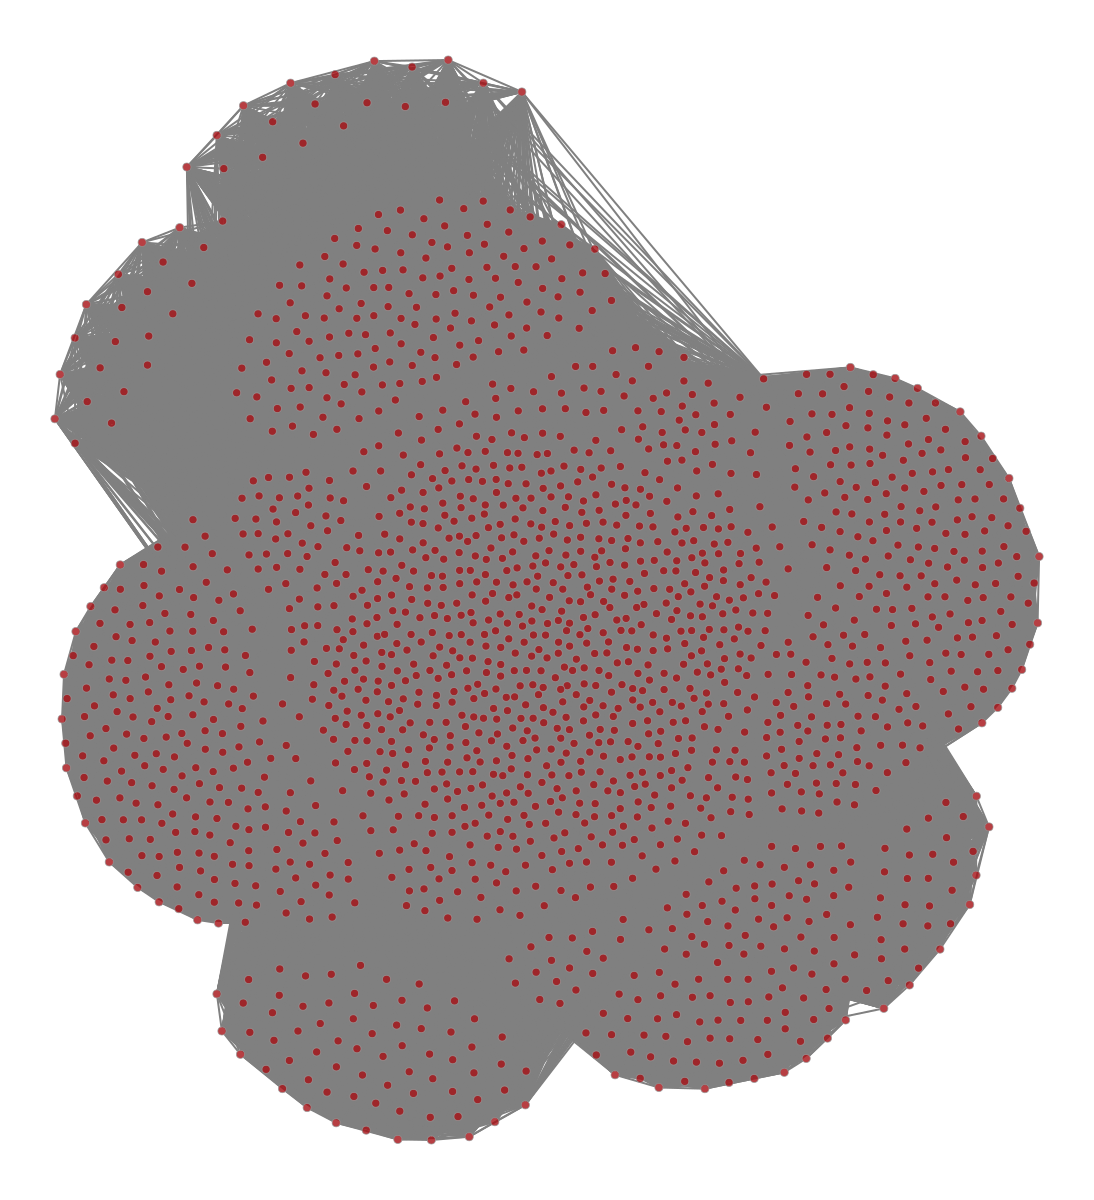

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f10030c3d40, at 0x7f10c82904a0>

In [13]:
u = gt.GraphView(g, vfilt=lambda x: x.in_degree() + x.out_degree() > 1)
gt.graph_draw(u, edge_pen_width=edge_weight, edge_color="gray")

Dropdown(description='Main category:', index=1, options=('reinforcement learning', 'evolutionary algorithms', …

Dropdown(description='Highlight:', index=3, options=('reinforcement learning', 'evolutionary algorithms', 'bay…

Button(button_style='success', description='Click Me', style=ButtonStyle(), tooltip='Click this button')

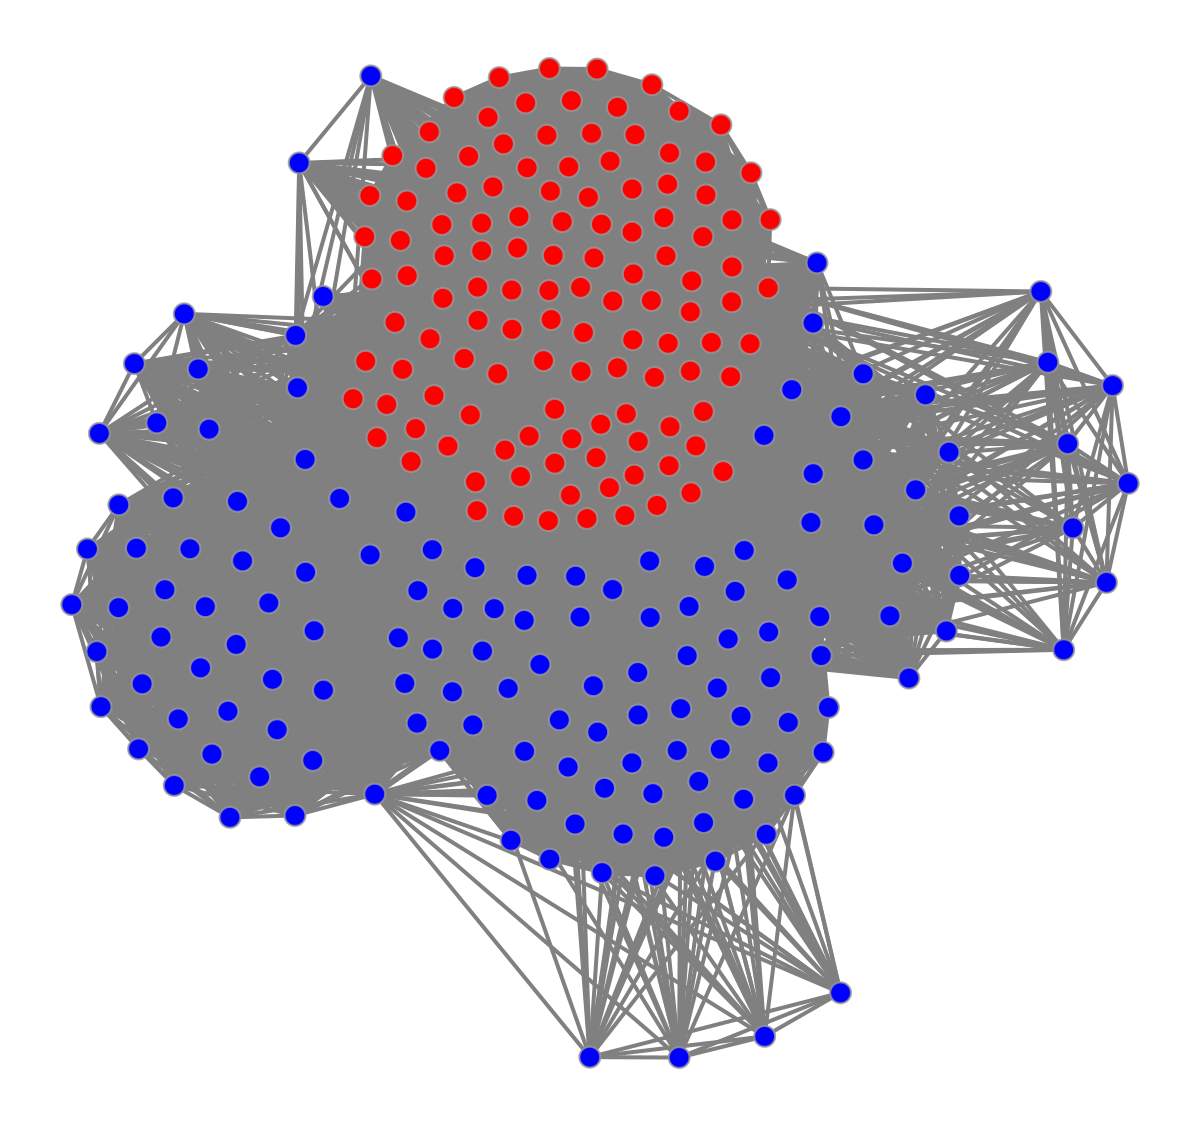

finished


Output()

In [14]:
import ipywidgets as widgets
from IPython.display import display

MAIN_CATEGORY="evolutionary algorithms"
HIGHLIGHT="multi-objective optimisation"

dropdown1 = widgets.Dropdown(
    options=df_keywords.columns,
    value='evolutionary algorithms',
    description='Main category:',
    disabled=False,
)
dropdown2 = widgets.Dropdown(
    options=df_keywords.columns,
    value='multi-objective optimisation',
    description='Highlight:',
    disabled=False,
)

def is_category(id, keyword):
    return df_keywords.loc[id, keyword]

def gdraw():
    node_color = g.new_vp("string")
    for node in g.vertices():
        node_color[node] = "red" if is_category(node_id[node], HIGHLIGHT) else "blue"

    evo_part = gt.GraphView(g, efilt=lambda e: edge_weight[e]>1, vfilt=lambda v: is_category(node_id[v], MAIN_CATEGORY))
    evo_part = gt.GraphView(evo_part, vfilt=lambda v: evo_part.get_total_degrees([v])>1)

    gt.graph_draw(evo_part, edge_pen_width=edge_weight, edge_color="gray",
                         vertex_fill_color=node_color, inline=True)
    
    print("finished")

button = widgets.Button(
    description="Click Me",
    tooltip="Click this button",
    button_style="success", 
)

out = widgets.Output()
# Define the button clickevent
def on_button_click(b):
    global MAIN_CATEGORY, HIGHLIGHT

    MAIN_CATEGORY = dropdown1.value
    HIGHLIGHT = dropdown2.value
    with out:
        print(MAIN_CATEGORY, HIGHLIGHT)
        gdraw()

# Attach the event to the button
button.on_click(on_button_click)

# Display the button
display(dropdown1, dropdown2,button)
gdraw()
out

## LLM keywords

In [15]:
llm_keywords = read_keyword_lists(data_dir) 

In [16]:
set_of_keywords = set()
for small_set in llm_keywords.values():
    set_of_keywords.update(small_set)
len(set_of_keywords)

6399

In [83]:
paper2node = {}
index2node = {} 
g2 = gt.Graph(directed=False)
node_index = g2.new_vp("int")
node_id = g2.new_vp("string")
node_title = g2.new_vp("string")
node_authors = g2.new_vp("string")

for i, row in df.iterrows():
    paper = row["id"]
    node = g2.add_vertex()
    paper2node[paper] = node
    index2node[i] = node 
    node_id[node] = paper
    node_index[node] = i
    node_title[node] = row["title"].replace("\n", " ")
    node_authors[node] = row["authors"]

In [84]:
edge_size = g2.new_ep("int")
for paper1, paper2 in tqdm.tqdm(combinations(df["id"], 2), total=math.comb(len(df), 2)):
    common = llm_keywords[paper1].intersection(llm_keywords[paper2])
    if len(common) > 1:
        e = g2.add_edge(paper2node[paper1], paper2node[paper2])
        edge_size[e] = len(common)
len(list(g2.edges()))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2934253/2934253 [00:01<00:00, 1672113.61it/s]


3184

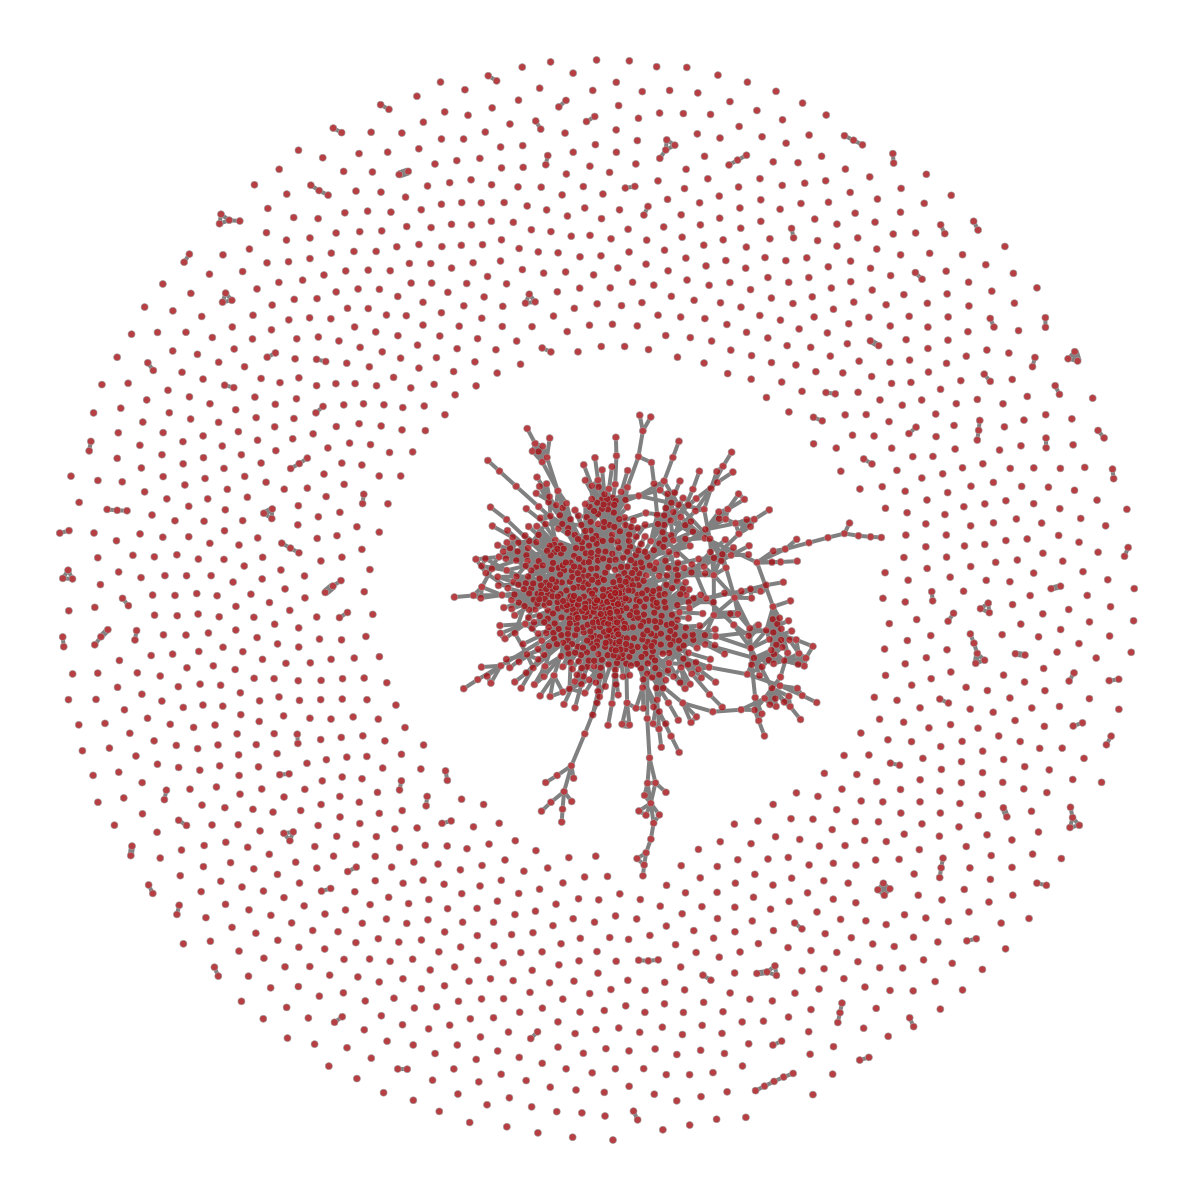

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0face0d490, at 0x7f0fad062de0>

In [85]:
gt.graph_draw(g2, edge_pen_width=edge_size, edge_color="gray")

In [100]:
df["hutter"] = df["authors"].apply(lambda x: "Hutter" in x)
print(df["hutter"].count(), df["hutter"].sum())

df["schmidhuber"] = df["authors"].apply(lambda x: "Schmidhuber" in x)
df["schmidhuber"].sum()

2423 43


1

In [126]:
hutter_color = g2.new_vp("string", val="blue")
hutter_size = g2.new_vp("int", val=5)
for i, row in df[df["hutter"]].iterrows():
    hutter_color[paper2node[row["id"]]] = "red"
    hutter_size[paper2node[row["id"]]] = 10

paper = df[df["schmidhuber"]]["id"].iloc[0]
hutter_color[paper2node[paper]] = "violet"
hutter_size[paper2node[paper]] = 20

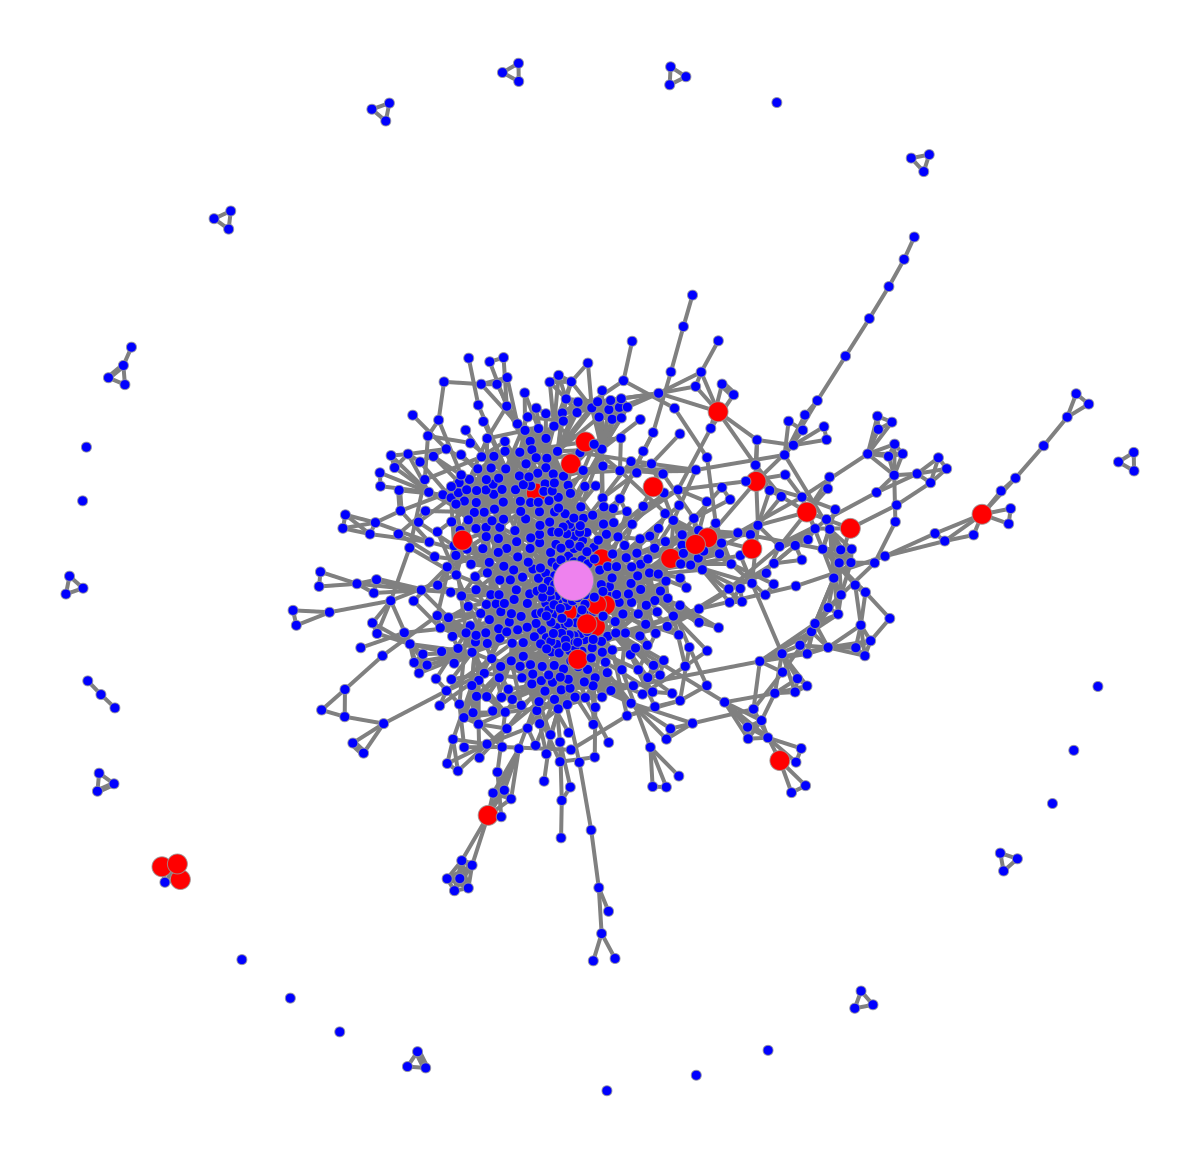

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0f8d795670, at 0x7f0f9182ecc0>

In [127]:
u = gt.GraphView(g2, vfilt=lambda v: v.in_degree() + v.out_degree() > 1)
gt.graph_draw(u, edge_pen_width=edge_size, edge_color="gray", vertex_fill_color=hutter_color,
             vertex_size=hutter_size)

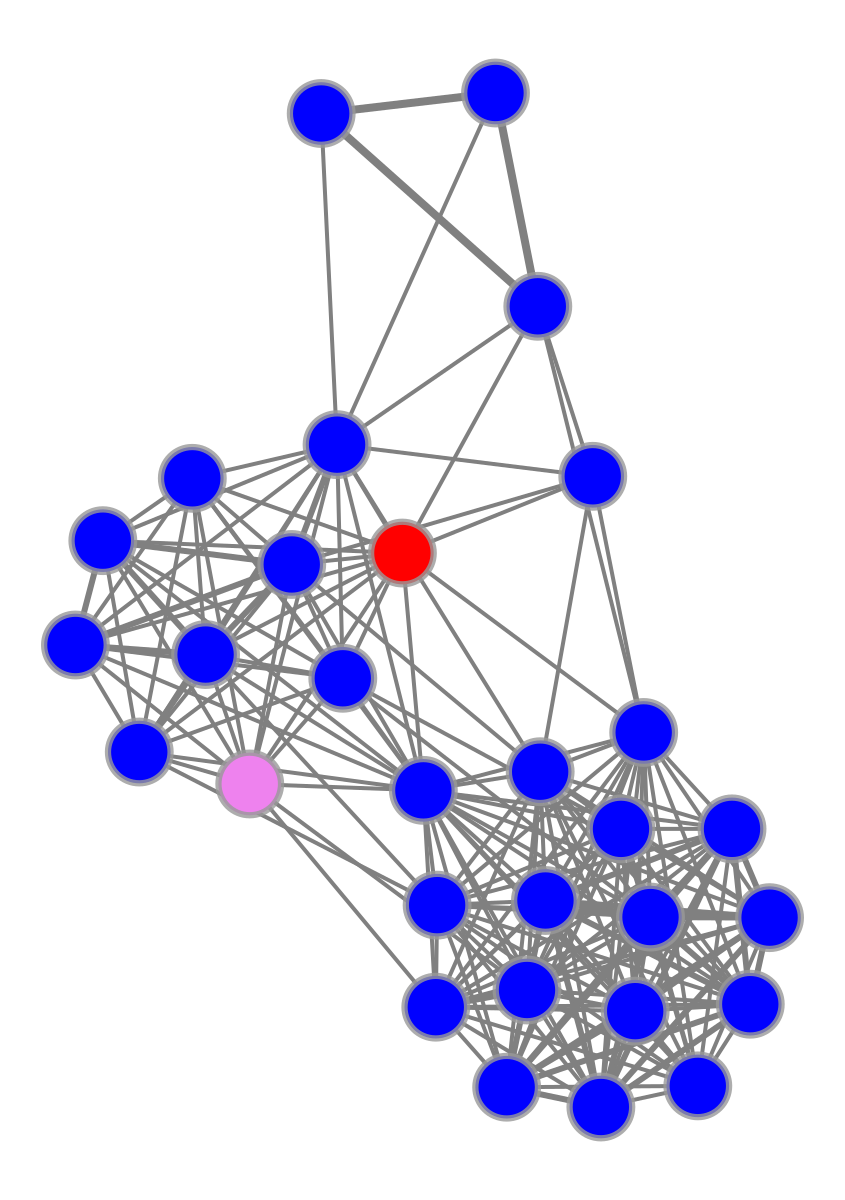

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0faca61970, at 0x7f0f8d7954f0>

In [128]:

node_fractions = g2.new_vp("vector<int>")
node_colors = g2.new_vp("vector<string>")

color_dict = {}
colors = ["red", "green", "blue", "orange", "magenta", "lightblue", "yellow", "violet", "white", "darkblue"]
for i, keyword in enumerate([k for k in df_keywords.columns]):
        color_dict[keyword] = colors[i]
for node in g2.vertices():
    paper = node_id[node]
    row = df_keywords.loc[paper]
    keywords = list(row.index[row])
    if not keywords:
        node_colors[node] = ["black"]
        node_fractions[node] = [1.0]
        continue
    node_colors[node] = [color_dict[keyword] for keyword in keywords if keyword]
    fractions =  [round(1/len(keywords), 2) for k in keywords]
    fractions[-1] += 1.0 - sum(fractions)
    node_fractions[node] = fractions

vcolor = g2.new_vp("string")
for node in g2.vertices():
    vcolor[node] = "red" if is_category(node_id[node], HIGHLIGHT) else "blue"
u2 = gt.GraphView(g2, vfilt=lambda v: v.in_degree() + v.out_degree() > 30)
gt.graph_draw(u2, edge_pen_width=edge_size, edge_color="gray",
             vertex_fill_color=hutter_color
              #vertex_fill_color=vcolor
             #vertex_shape="pie", vertex_pie_colors=node_colors, vertex_pie_fractions=node_fractions
             )

In [93]:
for node in u.vertices():
    print(node_authors[node], ":", node_title[node])

Nilotpal Sinha;Kuan-Wen Chen : Neural Architecture Search using Progressive Evolution
Gerard Jacques van Wyk;Anna Sergeevna Bosman : Evolutionary Neural Architecture Search for Image Restoration
Huafeng Qin;Hongyu Zhu;Xin Jin;Xin Yu;Mounim A. El-Yacoubi;Shuqiang Yang : EM-DARTS: Hierarchical Differentiable Architecture Search for Eye   Movement Recognition
Yuhei Noda;Shota Saito;Shinichi Shirakawa : Efficient Search of Multiple Neural Architectures with Different   Complexities via Importance Sampling
Difan Deng;Marius Lindauer : Optimizing Time Series Forecasting Architectures: A Hierarchical Neural   Architecture Search Approach
Hangyu Zhu;Haoyu Zhang;Yaochu Jin : From Federated Learning to Federated Neural Architecture Search: A   Survey
Nanyang Ye;Jingbiao Mei;Zhicheng Fang;Yuwen Zhang;Ziqing Zhang;Huaying Wu;Xiaoyao Liang : BayesFT: Bayesian Optimization for Fault Tolerant Neural Network   Architecture
Ye Qiao;Haocheng Xu;Yifan Zhang;Sitao Huang : MicroNAS: Zero-Shot Neural Archit

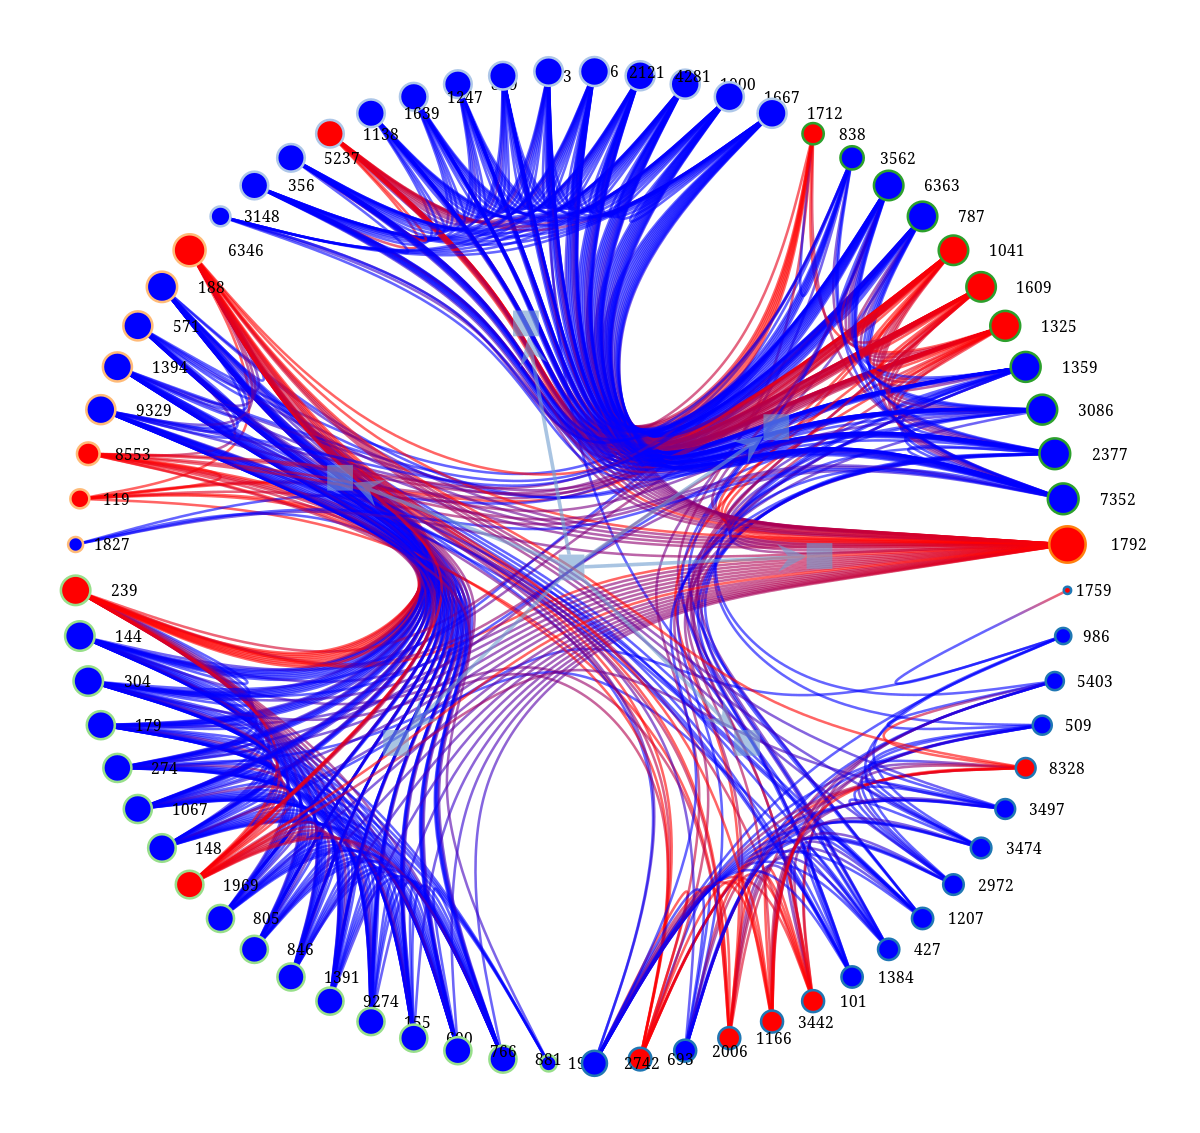

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0f8d793770, at 0x7f0f9182ef90>,
 <GraphView object, directed, with 75 vertices and 74 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f0facabca70, at 0x7f0facabf980>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f0facabca70, at 0x7f0facabecf0>, False), at 0x7f0facabca70>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0facabca70, at 0x7f0facaa6b40>)

In [129]:
u3 = gt.GraphView(g2, vfilt=lambda x: x.in_degree() + x.out_degree() > 20) 
state = gt.minimize_nested_blockmodel_dl(u3)
state.draw(vertex_fill_color=vcolor, vertex_text=node_index, vertex_text_position=0)

In [130]:
node_title[index2node[1792]]

'RL-Based Hyperparameter Selection for Spectrum Sensing With CNNs'

title  \
38    Construction of Hierarchical Neural Architectu...   
88    Differential Evolution for Neural Architecture...   
188   Neural Architecture Search: Insights from 1000...   
338   Smooth Variational Graph Embeddings for Effici...   
427   Neural Architecture Search for Dense Predictio...   
450   Efficient Multi-objective Neural Architecture ...   
465                Neural Architecture Search: A Survey   
589        Bag of Tricks for Neural Architecture Search   
595   Best Practices for Scientific Research on Neur...   
621   NAS-Bench-101: Towards Reproducible Neural Arc...   
714   Efficient Automated Deep Learning for Time Ser...   
732   Towards Automated Deep Learning: Efficient Joi...   
806   Bag of Baselines for Multi-objective Joint Neu...   
821   Neural Ensemble Search for Uncertainty Estimat...   
843   Raiders of the Lost Architecture: Kernels for ...   
847   Multi-objective Differentiable Neural Architec...   
864   Weight-Entanglement Meets Gradient-Based Neura...   
1086  Surrogate NAS Benchmarks: Going Beyond the Lim...   
1141  Simple And Efficient Architecture Search for C...   
1218  Meta-Learning of Neural Architectures for Few-...   
1248  Neural Architecture Evolution in Deep Reinforc...   
1282  How Powerful are Performance Predictors in Neu...   
1327  Rethinking Bias Mitigation: Fairer Architectur...   
1352  NAS-Bench-1Shot1: Benchmarking and Dissecting ...   
1433                Multi-headed Neural Ensemble Search   
1451     NAS-Bench-x11 and the Power of Learning Curves   
1588  Efficient Search for Customized Activation Fun...   
1589  AutoDispNet: Improving Disparity Estimation Wi...   
1629  DEHB: Evolutionary Hyperband for Scalable, Rob...   
1725  Surprisingly Strong Performance Prediction wit...   
1735  HW-GPT-Bench: Hardware-Aware Architecture Benc...   
1886  MO-DEHB: Evolutionary-based Hyperband for Mult...   
1915  Auto-PyTorch Tabular: Multi-Fidelity MetaLearn...   
1948  Compressing Large Language Models with Automat...   
1983  BOAH: A Tool Suite for Multi-Fidelity Bayesian...   
2106  NAS-Bench-Suite: NAS Evaluation is (Now) Surpr...   
2230  NAS-Bench-Suite-Zero: Accelerating Research on...   
2619  Understanding and Robustifying Differentiable ...   
2643  Hyperparameter Transfer Across Developer Adjus...   
2785  A Downsampled Variant of ImageNet as an Altern...   
2790  Towards Assessing the Impact of Bayesian Optim...   
3562  Winning solutions and post-challenge analyses ...   
8528  Deep learning with convolutional neural networ...   

                                                authors  \
38    Simon Schrodi;Danny Stoll;Binxin Ru;Rhea Sukth...   
88              Noor Awad;Neeratyoy Mallik;Frank Hutter   
188   Colin White;Mahmoud Safari;Rhea Sukthanker;Bin...   
338   Jovita Lukasik;David Friede;Arber Zela;Frank H...   
427   Thomas Elsken;Arber Zela;Jan Hendrik Metzen;Be...   
450       Thomas Elsken;Jan Hendrik Metzen;Frank Hutter   
465       Thomas Elsken;Jan Hendrik Metzen;Frank Hutter   
589   Thomas Elsken;Benedikt Staffler;Arber Zela;Jan...   
595                        Marius Lindauer;Frank Hutter   
621   Chris Ying;Aaron Klein;Esteban Real;Eric Chris...   
714   Difan Deng;Florian Karl;Frank Hutter;Bernd Bis...   
732   Arber Zela;Aaron Klein;Stefan Falkner;Frank Hu...   
806   Julia Guerrero-Viu;Sven Hauns;Sergio Izquierdo...   
821   Sheheryar Zaidi;Arber Zela;Thomas Elsken;Chris...   
843   Kevin Swersky;David Duvenaud;Jasper Snoek;Fran...   
847   Rhea Sanjay Sukthanker;Arber Zela;Benedikt Sta...   
864   Rhea Sanjay Sukthanker;Arjun Krishnakumar;Mahm...   
1086  Arber Zela;Julien Siems;Lucas Zimmer;Jovita Lu...   
1141      Thomas Elsken;Jan-Hendrik Metzen;Frank Hutter   
1218  Thomas Elsken;Benedikt Staffler;Jan Hendrik Me...   
1248  Jörg K. H. Franke;Gregor Köhler;Noor Awad;Fran...   
1282  Colin White;Arber Zela;Binxin Ru;Yang Liu;Fran...   
1327  Samuel Dooley;Rhea Sanjay Sukthanker;John P. D...   
1352               Arber Zela;Julien 